In [1]:
#Building a pumpp Feature Extractor for PCEN, and for PCEN varying T
import numpy as np
from pumpp import FeatureExtractor
from librosa import pcen, amplitude_to_db, get_duration
from librosa.feature import melspectrogram

def to_dtype(x, dtype):
    '''Convert an array to a target dtype.  Quantize if integrable.
    Parameters
    ----------
    x : np.ndarray
        The input data
    dtype : np.dtype or type specification
        The target dtype
    Returns
    -------
    x_dtype : np.ndarray, dtype=dtype
        The converted data.
        If dtype is integrable, `x_dtype` will be quantized.
    See Also
    --------
    quantize
    '''

    if np.issubdtype(dtype, np.integer):
        return quantize(x, dtype=dtype)
    else:
        return x.astype(dtype)

class PCEN(FeatureExtractor):
    '''PCEN of (log-)Mel Spectrogram extractor
    Attributes
    ----------
    name : str
        The name for this feature extractor
    sr : number > 0
        The sampling rate of audio
    hop_length : int > 0
        The number of samples between CQT frames
    log : boolean
        If `True`, scale the magnitude to decibels
        Otherwise, use linear magnitude
    n_mels:
        The number of frequency bins
   
    dtype : np.dtype
        The data type for the output features.  Default is `float32`.
        Setting to `uint8` will produce quantized features.
    '''
    def __init__(self, name, sr, hop_length, log=False, n_mels = 128,
                 dtype='float32'):

        super(PCEN, self).__init__(name, sr, hop_length, dtype=dtype) #not sure what this does

        self.log = log
        self.n_mels = n_mels
        self.register('mag', n_mels, self.dtype)


    def transform_audio(self, y):
        '''Compute the PCEN of the (log-) Mel Spectrogram        
        Parameters
        ----------
        y : np.ndarray
            The audio buffer
        Returns
        -------
        data : dict
            data['mag'] : np.ndarray, shape = (n_frames, n_bins)
                The PCEN magnitude
        '''
        #double audio and reverse pad to prevent zero initial-energy assumption
        
        y = np.concatenate((y[::-1],y))

        S = melspectrogram(y=y, sr=self.sr, hop_length=self.hop_length,
                          n_mels=self.n_mels)
        
        if self.log:
            S = amplitude_to_db(S, ref=np.max)
            
        P = pcen(S, sr=sr, hop_length=self.hop_length)
        P = P[:,P.shape[1]//2:] #remove padded section
        P = to_dtype(P, self.dtype)

        return {'mag': P[self.idx]} #copied from mel spectrogram pump feature extractor
    

In [2]:
import pumpp
import librosa as lr
from librosa import display, feature
import matplotlib.pyplot as plt
%matplotlib inline
DEMO_ID = "bimodal761"

DEMO_AUDIO_LOC = "/beegfs/ci411/pcen/URBAN-SED_v2.0.0/audio/train/soundscape_train_{}.wav".format(DEMO_ID)
DEMO_ANNOTATION_LOC = "/beegfs/ci411/pcen/URBAN-SED_v2.0.0/annotations/train/soundscape_train_{}.jams".format(DEMO_ID)


In [3]:
x_t, sr = lr.load(DEMO_AUDIO_LOC)
hop_length = 1024
p_pcen = PCEN(name='PCEN', sr=sr, hop_length=hop_length)
pump = pumpp.Pump(p_pcen)
data = pump(y=x_t, sr=sr)


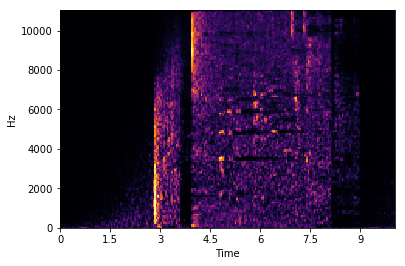

In [4]:
S = lr.feature.melspectrogram(y=x_t, sr=sr, hop_length=hop_length, n_mels = 128)
P = pcen(S, sr=sr, hop_length=hop_length)
lr.display.specshow(P, sr=sr, hop_length = hop_length,
                    x_axis='time', y_axis='hz', cmap='inferno')
plt.show()

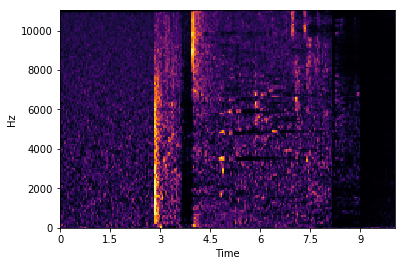

In [5]:
lr.display.specshow(data['PCEN/mag'][0], sr=sr, hop_length=hop_length,
                    x_axis='time', y_axis='hz', cmap='inferno')
plt.show()

In [6]:
(data['PCEN/mag'][0]).shape

(128, 216)

In [7]:
P.shape

(128, 216)

In [8]:
class PCEN_T(FeatureExtractor):
    '''PCEN of (log-)Mel Spectrogram extractor with varying T-constants
    Attributes
    ----------
    name : str
        The name for this feature extractor
    sr : number > 0
        The sampling rate of audio
    hop_length : int > 0
        The number of samples between CQT frames
    log : boolean
        If `True`, scale the magnitude to decibels
        Otherwise, use linear magnitude
    n_mels:
        The number of frequency bins
    n_t_constants:
        The number of T constants to layer
    dtype : np.dtype
        The data type for the output features.  Default is `float32`.
        Setting to `uint8` will produce quantized features.
    '''
    def __init__(self, name, sr, hop_length, log=False, n_mels = 128, n_t_constants = 8,
                 dtype='float32', conv='channels_last'):

        super(PCEN_T, self).__init__(name, sr, hop_length, dtype=dtype, conv=conv) #not sure what this does

        self.log = log
        self.n_mels = n_mels
        self.n_t_constants = n_t_constants
        self.register('mag', n_mels, self.dtype, channels=n_t_constants)

    def transform_audio(self, y):
        '''Compute the PCEN of the (log-) Mel Spectrogram        
        Parameters
        ----------
        y : np.ndarray
            The audio buffer
        Returns
        -------
        data : dict
            data['mag'] : np.ndarray, shape = (n_frames, n_bins)
                The PCEN magnitude
        '''
        
        #double audio and reverse pad to prevent zero initial-energy assumption
        y = np.concatenate((y[::-1],y))

        #n_frames = self.n_frames(get_duration(y=y, sr=self.sr))
        
        S = melspectrogram(y=y, sr=self.sr, hop_length=self.hop_length,
                          n_mels=self.n_mels)
        if self.log:
            S = amplitude_to_db(S, ref=np.max)
        
        t_base = (self.hop_length)/(self.sr) #tau, or hop length in time
        t_constants = t_base * np.array([2**i for i in range(self.n_t_constants)])
        pcen_layers = []
        
        for T in t_constants:   
            P = pcen(S, sr=self.sr, hop_length=self.hop_length, time_constant = T)
            P = P[:,P.shape[1]//2:] #remove padded section
            P = to_dtype(P, self.dtype)
            pcen_layers.append(P)
            
        pcen_layers = to_dtype(np.asarray(pcen_layers), self.dtype)

        return {'mag': self._index(pcen_layers)} #copied from mel spectrogram pump feature extractor
    
    def _index(self, value):
        '''Rearrange a tensor according to the convolution mode
        Input is assumed to be in (channels, bins, time) format.
        '''

        if self.conv in ('channels_last', 'tf'):
            return np.transpose(value, (2, 1, 0))

        else:  # self.conv in ('channels_first', 'th')
            return np.transpose(value, (0, 2, 1))

In [9]:
p_pcen_t = PCEN_T(name='PCEN', sr=sr, hop_length=hop_length)
pump_t = pumpp.Pump(p_pcen_t)
data_t = pump_t(y=x_t, sr=sr)

(216, 128)


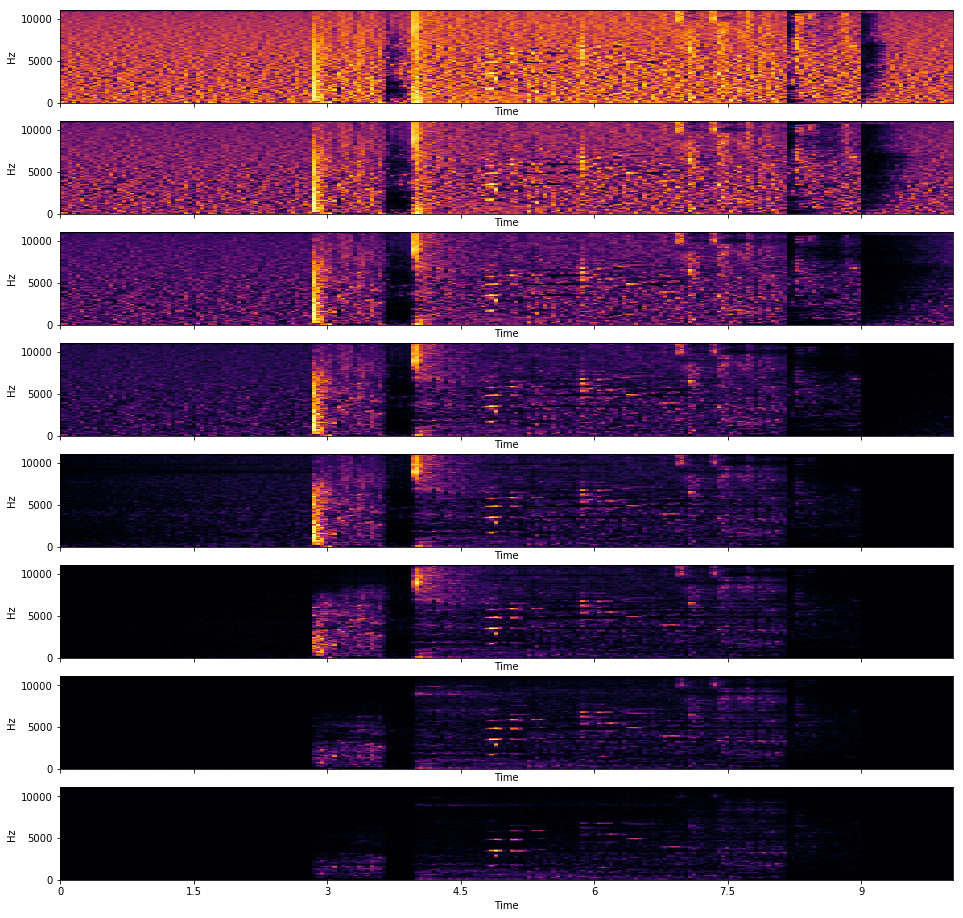

In [16]:
fig, ax = plt.subplots(nrows=8, sharex=True, figsize = (16,16))
for i, pcen_layer in enumerate(np.transpose(data_t['PCEN/mag'][0],(2,0,1))):
    lr.display.specshow(pcen_layer.T, sr=sr, hop_length=hop_length,
                    x_axis='time', y_axis='hz', cmap='inferno', ax=ax[i])
print(pcen_layer.shape)
plt.show()

In [11]:
from pumpp.feature import HCQT

hcqt = HCQT(name='HCQT', sr=sr, hop_length=hop_length)
pump_hcqt = pumpp.Pump(hcqt)
data_hcqt = pump_hcqt(y=x_t, sr=sr)
data_hcqt['HCQT/mag'][0].shape

(215, 288, 1)

In [12]:
p_pcen_t.layers()

Using TensorFlow backend.


{'PCEN/mag': <tf.Tensor 'PCEN/mag:0' shape=(?, ?, 128, 8) dtype=float32>}

In [13]:
pump_hcqt.layers()

{'HCQT/mag': <tf.Tensor 'HCQT/mag:0' shape=(?, ?, 288, 1) dtype=float32>,
 'HCQT/phase': <tf.Tensor 'HCQT/phase:0' shape=(?, ?, 288, 1) dtype=float32>}

In [14]:
p_pcen_t.layers()['PCEN/mag'].shape

TensorShape([Dimension(None), Dimension(None), Dimension(128), Dimension(8)])